In [18]:
import torch
from torchvision import datasets, transforms, models
from torch import nn 
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import numpy as np
from collections import OrderedDict

In [13]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


In [45]:
data_dir = "/kaggle/input/cats-and-dogs-image-classification"

train_transform = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
                               transforms.Resize(255), 
                               transforms.CenterCrop(224), 
                               transforms.RandomHorizontalFlip(True)])

test_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                     transforms.Resize(255), 
                               transforms.CenterCrop(224)
                                    ])
trainset = datasets.ImageFolder(data_dir + "/train", transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = datasets.ImageFolder(data_dir + "/test", transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)


<Axes: >

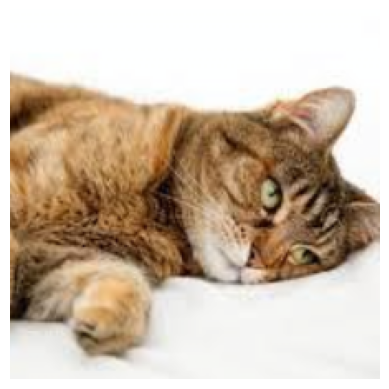

In [46]:
images, labels = next(iter(trainloader))
imshow(images[0])

In [47]:
model = models.densenet121(pretrained=True)


In [48]:
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)), 
    ('relu', nn.ReLU()), 
    ('fc2', nn.Linear(500, 2)), 
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [61]:



def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for inputs, labels in testloader:

        inputs, labels = inputs.to(device), labels.to(device)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [63]:
import time

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

device = 'cuda'
epochs = 15
print_every = 4
steps = 0
train_loss = 0
for e in range(epochs):
    model.to(device)
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        test_loss, test_acc = validation(model, testloader, criterion)
            
    print(f'epochs:{e+1}/{epochs}', 
      'train loss:{:.4f}, '.format(train_loss/print_every),
      'test loss:{:.4f}, '.format(test_loss/len(testloader)), 
      'test accuracy:{:.4f}'.format(test_acc/len(testloader)))
    model.train()
    train_loss = 0
     


epochs:1/15 train loss:1.4572,  test loss:0.4447,  test accuracy:0.9146
epochs:2/15 train loss:1.5424,  test loss:0.2851,  test accuracy:0.9438
epochs:3/15 train loss:1.1471,  test loss:0.2790,  test accuracy:0.9354
epochs:4/15 train loss:0.8260,  test loss:0.2922,  test accuracy:0.9396
epochs:5/15 train loss:0.7831,  test loss:0.1757,  test accuracy:0.9563
epochs:6/15 train loss:0.4820,  test loss:0.1732,  test accuracy:0.9521
epochs:7/15 train loss:0.6093,  test loss:0.1374,  test accuracy:0.9750
epochs:8/15 train loss:0.5872,  test loss:0.1335,  test accuracy:0.9750
epochs:9/15 train loss:0.5183,  test loss:0.1264,  test accuracy:0.9688
epochs:10/15 train loss:0.5187,  test loss:0.1387,  test accuracy:0.9583
epochs:11/15 train loss:0.4505,  test loss:0.1262,  test accuracy:0.9750
epochs:12/15 train loss:0.4189,  test loss:0.1316,  test accuracy:0.9750
epochs:13/15 train loss:0.4792,  test loss:0.1357,  test accuracy:0.9583
epochs:14/15 train loss:0.5278,  test loss:0.1196,  test acc